In [1]:
from visualizer import get_local
get_local.activate()

import os
ROOT_PATH="/data/aofei"
os.environ["CUDA_VISIBLE_DEVICES"] = '2'
os.environ["TRANSFORMERS_CACHE"] = f"{ROOT_PATH}/huggingface_cache/transformers"
os.environ["HF_HOME"] = f"{ROOT_PATH}/huggingface_cache/transformers"

from PIL import Image
import seaborn as sns
import torch
import torch.nn.functional as F
import json
import copy
import numpy as np

import sys
sys.path.append("/home/avc6555/research/MedH/Mitigation/LVLMs/llava-med")

from llava import LlavaLlamaForCausalLM
from llava.conversation import conv_templates
from llava.utils import disable_torch_init
from transformers import CLIPVisionModel, CLIPImageProcessor, StoppingCriteria
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoConfig

from PIL import Image
import random
import math

from utils import show_image_relevance

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:441: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/hub.py:123: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytree_node(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/utils/generic.py:309: UserWarning: torch.utils._pytree._register_pytree_node is deprecated. Please use torch.utils._pytree.register_pytree_node instead.
  _torch_pytree._register_pytr

In [2]:
# load model
ROOT_PATH="/data/aofei"
model_name = f"{ROOT_PATH}/LLM/llava_med"
# lora weights
dir="llava_med/lora/epoch3_bbox"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

DEFAULT_IMAGE_TOKEN = "<image>"
DEFAULT_IMAGE_PATCH_TOKEN = "<im_patch>"
DEFAULT_IM_START_TOKEN = "<im_start>"
DEFAULT_IM_END_TOKEN = "<im_end>"


In [3]:
model_name = os.path.expanduser(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

model = LlavaLlamaForCausalLM.from_pretrained(model_name, torch_dtype=torch.float16, use_cache=True).cuda()
# print("vision tower", model.config.mm_vision_tower)
image_processor = CLIPImageProcessor.from_pretrained(model.config.mm_vision_tower, torch_dtype=torch.float16)
vision_tower = model.model.vision_tower[0]
vision_tower.to(device='cuda', dtype=torch.float16)

mm_use_im_start_end = getattr(model.config, "mm_use_im_start_end", False)
tokenizer.add_tokens([DEFAULT_IMAGE_PATCH_TOKEN], special_tokens=True)
if mm_use_im_start_end:
    tokenizer.add_tokens([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN], special_tokens=True)

vision_config = vision_tower.config
vision_config.im_patch_token = tokenizer.convert_tokens_to_ids([DEFAULT_IMAGE_PATCH_TOKEN])[0]
vision_config.use_im_start_end = mm_use_im_start_end
if mm_use_im_start_end:
    vision_config.im_start_token, vision_config.im_end_token = tokenizer.convert_tokens_to_ids([DEFAULT_IM_START_TOKEN, DEFAULT_IM_END_TOKEN])
image_token_len = (vision_config.image_size // vision_config.patch_size) ** 2
print(image_token_len, "token length")

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
/data/aofei/conda/env/medh/lib/python3.10/site-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

256 token length


In [4]:
class KeywordsStoppingCriteria(StoppingCriteria):
    def __init__(self, keywords, tokenizer, input_ids):
        self.keywords = keywords
        self.tokenizer = tokenizer
        self.start_len = None
        self.input_ids = input_ids

    def __call__(self, output_ids: torch.LongTensor, scores: torch.FloatTensor, **kwargs) -> bool:
        if self.start_len is None:
            self.start_len = self.input_ids.shape[1]
        else:
            outputs = self.tokenizer.batch_decode(output_ids[:, self.start_len:], skip_special_tokens=True)[0]
            for keyword in self.keywords:
                if keyword in outputs:
                    return True
        return False

In [5]:
def get_attention_weights_example(model, question, image_path, conv_mode="simple"):
    qs = question.replace(DEFAULT_IMAGE_TOKEN, '').strip()
    
    image = Image.open(image_path)
    image_tensor = image_processor.preprocess(image, return_tensors='pt')['pixel_values'][0]
    images = image_tensor.unsqueeze(0).half().cuda()
    if getattr(model.config, 'mm_use_im_start_end', False):
        qs = DEFAULT_IM_START_TOKEN + DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + DEFAULT_IM_END_TOKEN + '\n' +  qs
    else:
        qs = DEFAULT_IMAGE_PATCH_TOKEN * image_token_len + '\n' + qs
    cur_prompt = '<image>' + '\n' +  qs

    conv = conv_templates[conv_mode].copy()
    conv.messages = []
    conv.append_message(conv.roles[0], qs)
    prompt = conv.get_prompt()
    inputs = tokenizer([prompt])

    input_ids = torch.as_tensor(inputs.input_ids).cuda()


    keywords = ['###']
    stopping_criteria = KeywordsStoppingCriteria(keywords, tokenizer, input_ids)
    

    with torch.inference_mode():
        outputs = model.generate(
            input_ids,
            images=images,
            do_sample=False,
            temperature=0.7,
            max_new_tokens=1024,
            output_attentions=True,
            return_dict_in_generate=True,
            stopping_criteria=[stopping_criteria])

    text = tokenizer.decode(outputs["sequences"][0]).strip()
    cache = get_local.cache
    print(text.split("###")[-2])
    return cache, text, outputs, input_ids, image

In [8]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
text.split("###")[-2]

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


' Assistant: The computed tomography (CT) image of the abdomen does not show any signs of liver cancer.\n'

In [9]:
question = "What is the largest organ in this image?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
text.split("###")[-2]

' Assistant: The largest organ in this image is the stomach.\n'

In [10]:
question = "What is the largest organ in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
text.split("###")[-2]

' Assistant: The largest organ in this chest X-ray image is the heart, which is located in the center of the chest, slightly tilted to the left.\n'

In [12]:
question = "Is the lungs normal in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
text.split("###")[-2]

' Assistant: Yes, the chest X-ray image shows normal lungs.\n'

In [35]:
# question = "Is there a liver in this image?"
# image_path = "./images/example1.jpg"
# cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
# text.split("###")[-2]

question = "Does the image show signs of a liver cancer?"
# question = "Does the image show a liver cancer?"
# question = "Is there a liver in this image?"
# question = "Is there any abnormity on the liver?" 
# question = "What is the abnormity on the liver?"
# question = "What is the disease shown in this image?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)
# text.split("###")[-2]

 Assistant: The image is a CT scan of the abdomen, and it does not show any signs of liver cancer.



In [6]:
import clip
_, preprocess = clip.load("ViT-B/32", device='cpu', jit=False)

In [57]:
input_ids.size()
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
# input_ids

38

li
ver


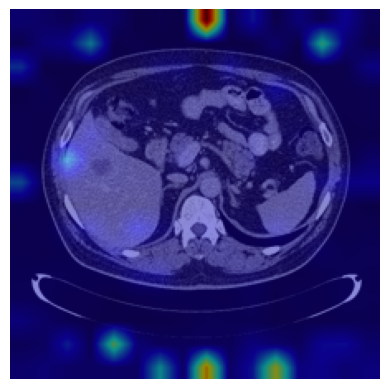

In [16]:
img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-6, -4):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

### After loading LoRA w/o attention tuning

In [7]:
from copy import deepcopy
model_copy3 = deepcopy(model)
# model_copy1 = deepcopy(model)
model_copy2 = deepcopy(model)

In [18]:
#LOAD LORA
dir="llava_med/lora/epoch3"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model = PeftModel.from_pretrained(model, peft_path)
    print(f"Merging weights")
    model = model.merge_and_unload()
    print('Convert to FP16...')
    model.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch3/checkpoints
Merging weights
Convert to FP16...


In [20]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

question = "Is there a liver in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

question = "Is the lungs normal in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes

 Assistant: Liver

 Assistant: Yes

 Assistant: Lung

 Assistant: No



 Assistant: Lung

L
ung




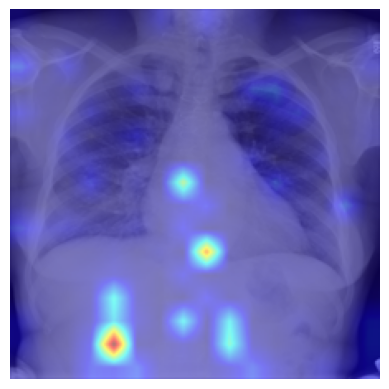

In [25]:
question = "What is the largest organ in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-5, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


 Assistant: Yes

the token: Yes


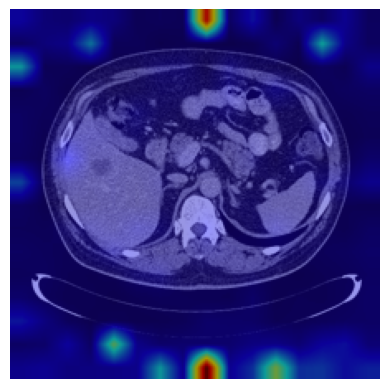

In [22]:

image_path = "./images/example1.jpg"
question = "Is there a liver in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print("the token:", token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0) 
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


In [39]:
#lora without attention tuning, lungs
#LOAD LORA
dir="llava_med/lora/epoch3_lung"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy0 = PeftModel.from_pretrained(model_copy0, peft_path)
    print(f"Merging weights")
    model_copy0 = model_copy0.merge_and_unload()
    print('Convert to FP16...')
    model_copy0.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch3_lung/checkpoints
Merging weights
Convert to FP16...


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes

Yes




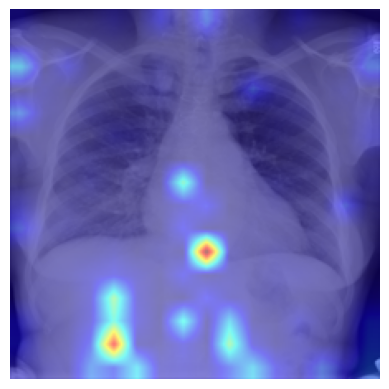

In [40]:
# question = "Is the lungs normal in this image?"
question = "Is there a nodule in the lungs in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

### After loading LoRA with attention tuning

In [23]:
#LOAD LORA
dir="llava_med/lora/epoch3_bbox"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy0 = PeftModel.from_pretrained(model_copy0, peft_path)
    print(f"Merging weights")
    model_copy0 = model_copy0.merge_and_unload()
    print('Convert to FP16...')
    model_copy0.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch3_bbox/checkpoints
Merging weights
Convert to FP16...


In [24]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

question = "Is there a liver in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

question = "Is the lungs normal in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

 Assistant: No

 Assistant: Liver

 Assistant: Yes

 Assistant: Lung

 Assistant: No



 Assistant: Yes

Yes




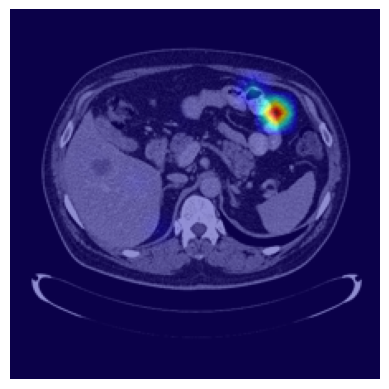

In [26]:
question = "Is there a liver in this image?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

 Assistant: No

No




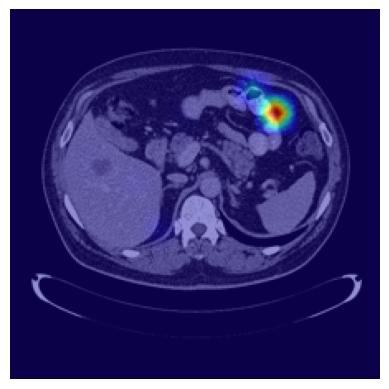

In [27]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


 Assistant: No

:
No




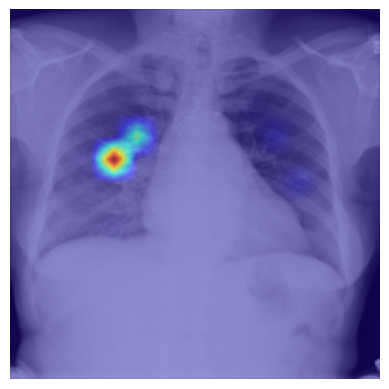

In [29]:
question = "Is the lungs normal in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy0, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-5, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


### After loading LoRA with attention tuning, on lungs

In [32]:
#LOAD LORA
dir="llava_med/lora/epoch3_bbox_lung"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy1 = PeftModel.from_pretrained(model_copy1, peft_path)
    print(f"Merging weights")
    model_copy1 = model_copy1.merge_and_unload()
    print('Convert to FP16...')
    model_copy1.to(torch.float16)


Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch3_bbox_lung/checkpoints
Merging weights
Convert to FP16...


In [33]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

question = "Is there a liver in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

question = "What is the largest organ in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

question = "Is the lungs normal in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: No

 Assistant: Liver

 Assistant: Yes

Assistant: Lung

 Assistant: No



 Assistant: Yes

Yes




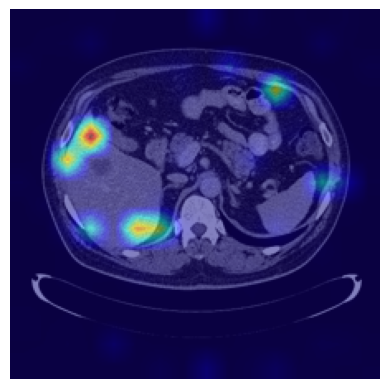

In [34]:
question = "Is there a liver in this image?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


 Assistant: No

No




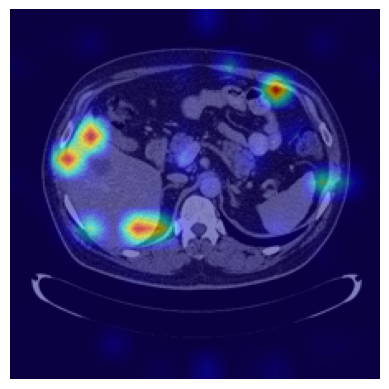

In [35]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


Assistant: Yes

Yes




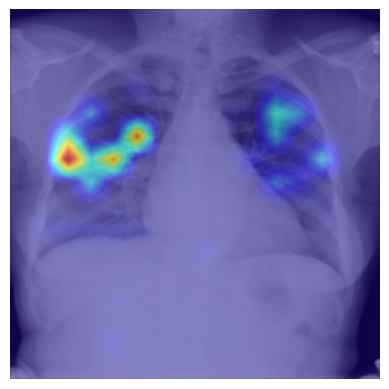

In [36]:
# question = "Is the lungs normal in this image?"
question = "Is there a nodule in the lungs in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

Assistant: Yes

Yes




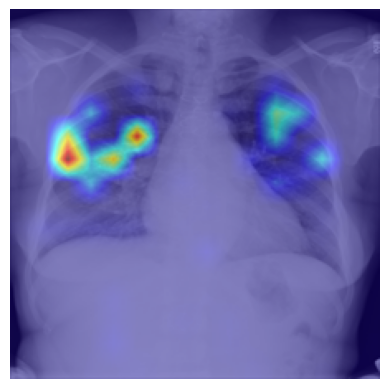

In [38]:
question = "Is there a heart in this image?"
image_path = "./images/example2.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy1, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)

In [20]:
#LOAD LORA
dir="llava_med/lora/epoch6_bbox_abd/0.05"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy3 = PeftModel.from_pretrained(model_copy3, peft_path)
    print(f"Merging weights")
    model_copy3 = model_copy3.merge_and_unload()
    print('Convert to FP16...')
    model_copy3.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch6_bbox_abd/0.05/checkpoints
Merging weights
Convert to FP16...


In [8]:
#LOAD LORA
dir="llava_med/lora/epoch6_bbox_abd/0.25"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy2 = PeftModel.from_pretrained(model_copy2, peft_path)
    print(f"Merging weights")
    model_copy2 = model_copy2.merge_and_unload()
    print('Convert to FP16...')
    model_copy2.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch6_bbox_abd/0.25/checkpoints
Merging weights
Convert to FP16...


 Assistant: Liver Cancer

cer <<<< token


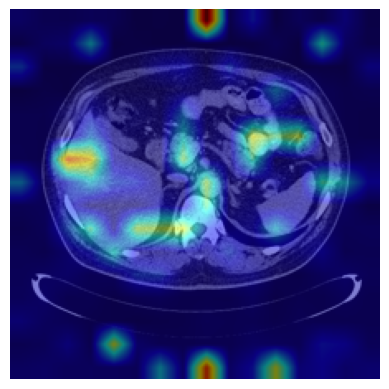

In [29]:
# question = "Does the image show signs of a liver cancer?"
# question = "Does the image show a liver cancer?"
# question = "Is there a liver in this image?"
# question = "Is there any abnormity on the liver?" 
# question = "What is the abnormity on the liver?"
question = "What is the disease shown?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy3, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "<<<< token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/utils.py:1518: UserWarning: You have modified the pretrained model configuration to control generation. This is a deprecated strategy to control generation and will be removed soon, in a future version. Please use and modify the model generation configuration (see https://huggingface.co/docs/transformers/generation_strategies#default-text-generation-configuration )
  warnings.warn(
/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes

the token: Yes
the token: 



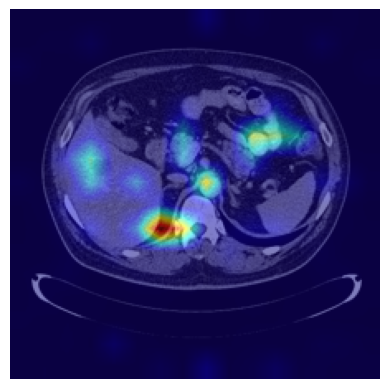

In [12]:

image_path = "./images/example1.jpg"
question = "Is there a liver in this image?"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy2, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -2):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print("the token:", token)
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0) 
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


 Assistant: No

No <<<< token


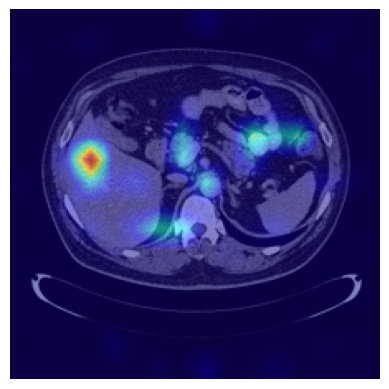

In [17]:
question = "Does the image show any signs of liver cancer?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy2, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "<<<< token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


/data/aofei/conda/env/medh/lib/python3.10/site-packages/transformers/generation/configuration_utils.py:389: UserWarning: `do_sample` is set to `False`. However, `temperature` is set to `0.7` -- this flag is only used in sample-based generation modes. You should set `do_sample=True` or unset `temperature`.
  warnings.warn(


 Assistant: Yes

Yes <<<< token


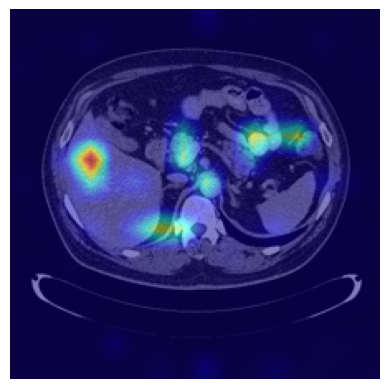

In [20]:
# question = "Does the image show any signs of liver cancer?"
question = "Is there any abnormity on the liver?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy2, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "<<<< token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)


### Wihtout bboxes, tuning 6 epochs, abd

In [8]:
#LOAD LORA
dir="llava_med/lora/epoch6_abd"
dataset="Slake"
peft_path = f"{ROOT_PATH}/hallucination/mitigation/{dataset}/{dir}/checkpoints"

if peft_path is not None and len(str(peft_path))>4:
    from peft import PeftModel
    print(f"Loading LoRA weights from {peft_path}")
    model_copy3 = PeftModel.from_pretrained(model_copy3, peft_path)
    print(f"Merging weights")
    model_copy3 = model_copy3.merge_and_unload()
    print('Convert to FP16...')
    model_copy3.to(torch.float16)

Loading LoRA weights from /data/aofei/hallucination/mitigation/Slake/llava_med/lora/epoch6_abd/checkpoints
Merging weights
Convert to FP16...


 Assistant: Liver Cancer

cer <<<< token


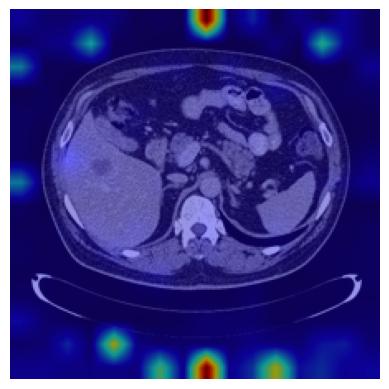

In [14]:
# question = "Does the image show any signs of liver cancer?"
# question = "Does the image show signs of a liver cancer?"
# question = "Does the image show a liver cancer?"
# question = "Is there a liver in this image?"
# question = "Is there any abnormity on the liver?" 
# question = "What is the abnormity on the liver?"
# question = "What is the disease shown?"
# question = "Is there any abnormity on the liver?"
image_path = "./images/example1.jpg"
cache, text, outputs, input_ids, image = get_attention_weights_example(model=model_copy3, question=question, image_path=image_path)

img_token_idx = int(torch.where(input_ids[0] == 32001)[0][0])
img_token_idx
for i in range(-4, -3):
    attn_all_layers = outputs['attentions'][i]
    token = tokenizer.decode(outputs["sequences"][0][i])
    print(token, "<<<< token")
    attn_all_layers_tensor = torch.cat(attn_all_layers, 0).mean(0)
    fig = show_image_relevance(attn_all_layers_tensor[:, :, img_token_idx:img_token_idx+256].mean(axis=0).mean(axis=0), image, orig_image=image, mask=None, preprocess=preprocess, only_map=True, show_mask=False)
